In [ ]:
#| hide
import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Conformal Prediction

> In this example, we'll implement conformal prediction

::: {.callout-warning collapse="true"}

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short.ipynb) 
:::

## Introduction 

When we generate a forecast, we usually produce a single value known as the point forecast. This value, however, doesn't tell us anything about the uncertainty associated with the forecast. To have a measure of this uncertainty, we need **prediction intervals**. 

A prediction interval is a range of values that the forecast can take with a given probability. Hence, a 95% prediction interval should contain a range of values that include the actual future value with probability 95%. Probabilistic forecasting aims to generate the full forecast distribution. Point forecasting, on the other hand, usually returns the mean or the median or said distribution. However, in real-world scenarios, it is better to forecast not only the most probable future outcome, but many alternative outcomes as well. 

The problem is that some timeseries models provide forecast distributions, but some other ones only provide point forecasts. How can we then estimate the uncertainty of predictions? 

::: {.callout-important}
## Prediction Intervals
For models that already provide the forecast distribution, check [Prediction Intervals](./UncertaintyIntervals.ipynb). 
:::

### Conformal Prediction

For a video introduction, see the [PyData Seattle presentation](https://www.youtube.com/watch?v=Bj1U-Rrxk48).

Multi-quantile losses and statistical models can provide provide prediction intervals, but the problem is that these are uncalibrated, meaning that the actual frequency of observations falling within the interval does not align with the confidence level associated with it. For example, a calibrated 95% prediction interval should contain the true value 95% of the time in repeated sampling. An uncalibrated 95% prediction interval, on the other hand, might contain the true value only 80% of the time, or perhaps 99% of the time. In the first case, the interval is too narrow and underestimates the uncertainty, while in the second case, it is too wide and overestimates the uncertainty. 

Statistical methods also assume normality. Here, we talk about another method called conformal prediction that doesn't require any distributional assumptions. More information on the approach can be found in [this repo owned by Valery Manokhin](https://github.com/valeman/awesome-conformal-prediction).

Conformal prediction intervals use cross-validation on a point forecaster model to generate the intervals. This means that no prior probabilities are needed, and the output is well-calibrated. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

[Statsforecast](https://github.com/nixtla/statsforecast) now supports Conformal Prediction on all available models.

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation.ipynb)

Install the necessary packages using `pip install statsforecast`

In [ ]:
%%capture
pip install statsforecast -U

## Load and explore the data

For this example, we'll use the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). We first need to download the data from a URL and then load it as a `pandas` dataframe. Notice that we'll load the train and the test data separately. We'll also rename the `y` column of the test data as `y_test`.   

In [ ]:
import pandas as pd 

train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [ ]:
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


Since the goal of this notebook is to generate prediction intervals, we'll only use the first 8 series of the dataset to reduce the total computational time. 

In [ ]:
n_series = 8 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the `statsforecast.plot` method from the [StatsForecast](https://nixtla.github.io/statsforecast/core.html#statsforecast) class. This method has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`]. 
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models. 
- `plot_random`: bool = `True`. Plots the time series randomly. 
- `models`: List[str]. A list with the models we want to plot. 
- `level`: List[float]. A list with the prediction intervals we want to plot. 
- `engine`: str = `plotly`. It can also be `matplotlib`. `plotly` generates interactive plots, while `matplotlib` generates static plots. 

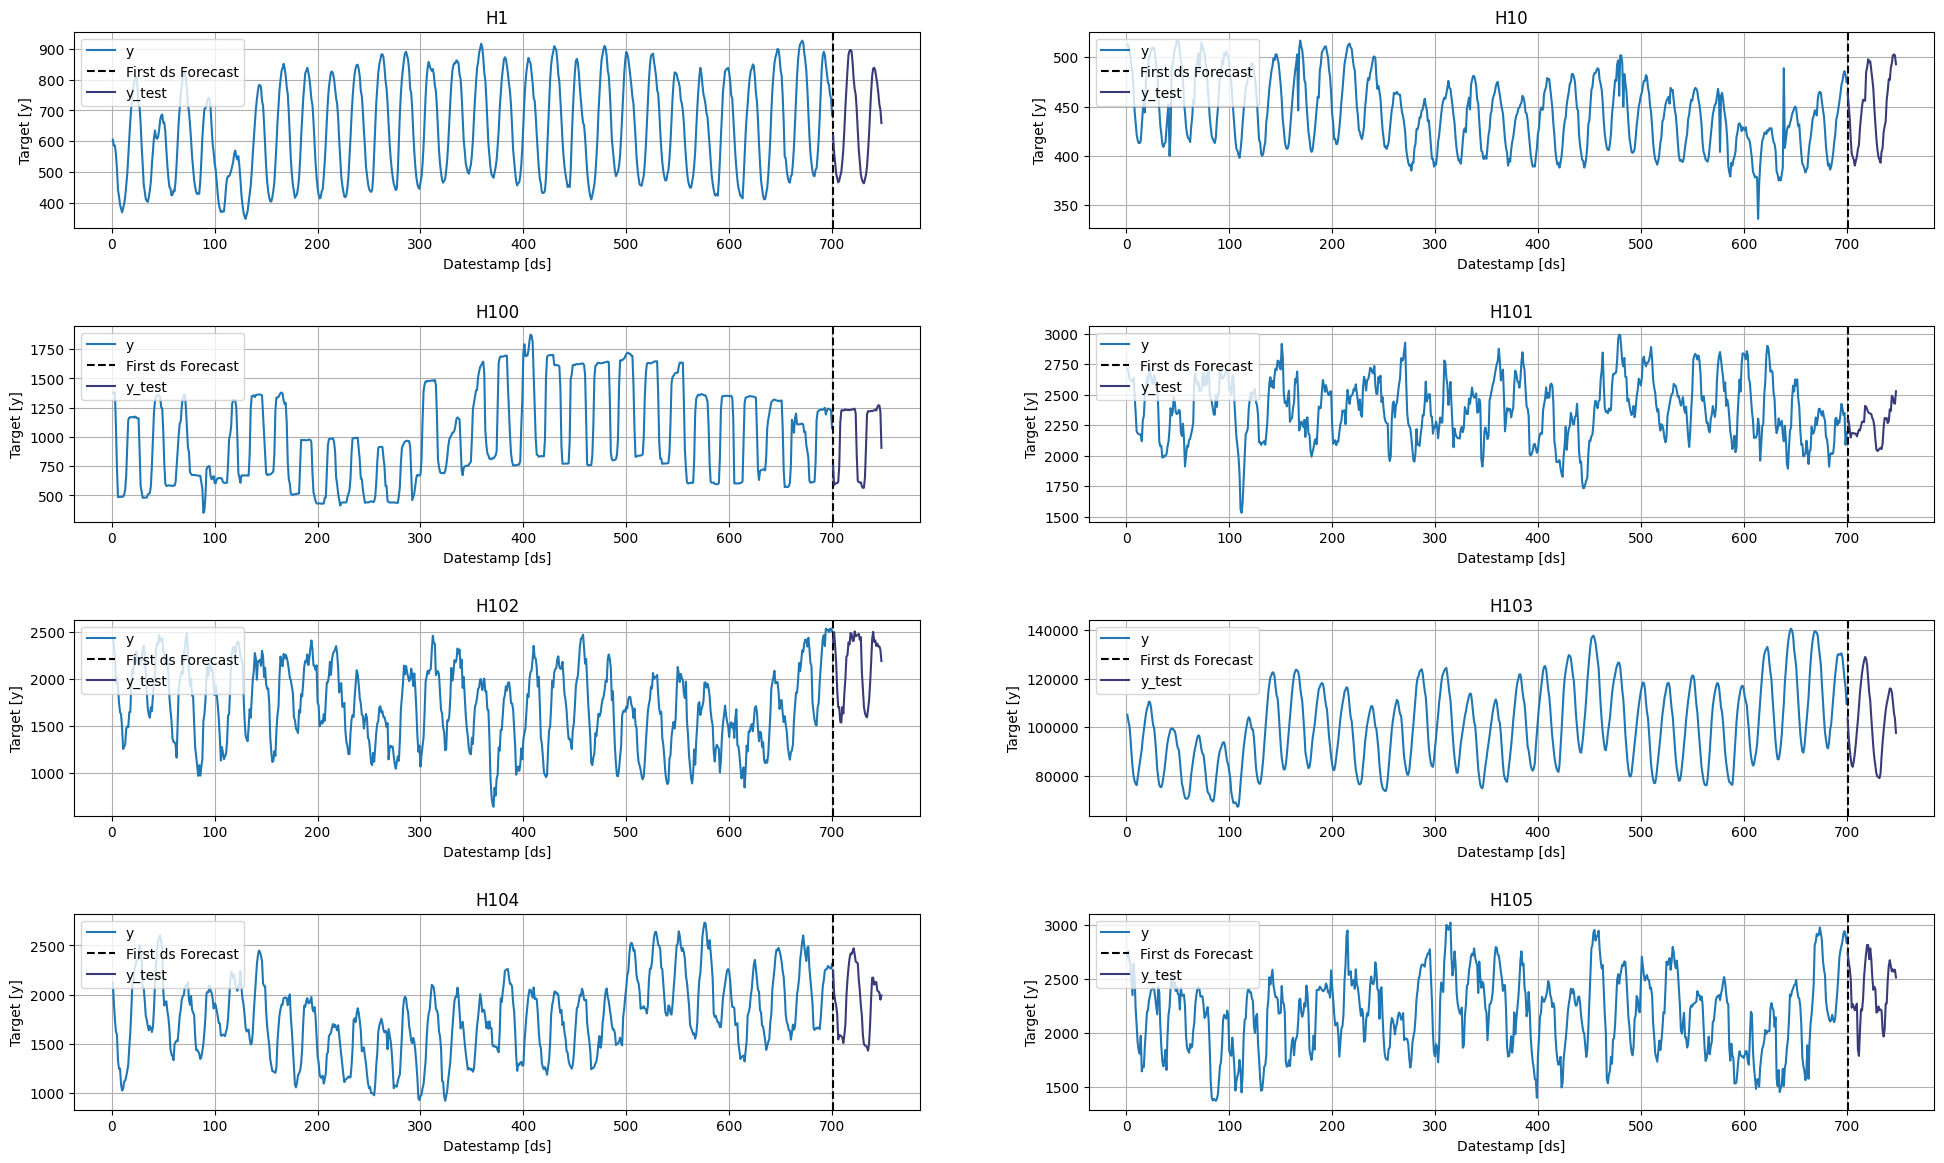

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(train, test, plot_random = False)

## Train models

StatsForecast can train multiple [models](https://nixtla.github.io/statsforecast/#models) on different time series efficiently. Most of these models can generate a probabilistic forecast, which means that they can produce both point forecasts and prediction intervals. 

For this example, we'll use [SimpleExponentialSmoothing](https://nixtla.github.io/statsforecast/src/core/models.html#simpleexponentialsmoothing) and [ADIDA](https://nixtla.github.io/statsforecast/src/core/models.html#adida) which do not provide a prediction interval natively. Thus, it makes sense to use Conformal Prediction to generate the prediction interval. 

We'll also show using it with [ARIMA](https://nixtla.github.io/statsforecast/src/core/models.html#arima) to provide prediction intervals that don't assume normality.

To use these models, we first need to import them from `statsforecast.models` and then we need to instantiate them.

In [ ]:
from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA
from statsforecast.utils import ConformalIntervals

# Create a list of models and instantiation parameters 
intervals = ConformalIntervals(h=24, n_windows=2)

models = [
    SeasonalExponentialSmoothing(season_length=24,alpha=0.1, prediction_intervals=intervals),
    ADIDA(prediction_intervals=intervals),
    ARIMA(order=(24,0,12), season_length=24, prediction_intervals=intervals),
]

To instantiate a new StatsForecast object, we need the following parameters: 

- `df`: The dataframe with the training data. 
- `models`: The list of models defined in the previous step.  
- `freq`: A string indicating the frequency of the data. See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores. 

In [ ]:
sf = StatsForecast(
    df=train, 
    models=models, 
    freq='H', 
) 

Now we're ready to generate the forecasts and the prediction intervals. To do this, we'll use the `forecast` method, which takes two arguments: 

- `h`: An integer that represent the forecasting horizon. In this case, we'll forecast the next 24 hours. 
- `level`: A list of floats with the confidence levels of the prediction intervals. For example, `level=[95]` means that the range of values should include the actual future value with probability 95%. 

In [ ]:
levels = [80, 90] # confidence levels of the prediction intervals 

forecasts = sf.forecast(h=24, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

,unique_id,ds,SeasonalES,SeasonalES-lo-90,SeasonalES-lo-80,SeasonalES-hi-80,SeasonalES-hi-90,ADIDA,ADIDA-lo-90,ADIDA-lo-80,ADIDA-hi-80,ADIDA-hi-90,ARIMA,ARIMA-lo-90,ARIMA-lo-80,ARIMA-hi-80,ARIMA-hi-90
0,H1,701,624.132690,561.315369,565.365356,682.900024,686.950012,747.292542,668.049988,672.099976,822.485107,826.535095,634.355164,581.760376,585.810364,682.900024,686.950012
1,H1,702,555.698181,501.886902,510.377441,601.018921,609.509460,747.292542,560.200012,570.400024,924.185059,934.385071,578.701355,540.992310,542.581909,614.820801,616.410400
2,H1,703,514.403015,468.656036,471.506042,557.299988,560.150024,747.292542,546.849976,549.700012,944.885071,947.735107,544.308960,528.375244,531.132568,557.485352,560.242676
3,H1,704,482.057892,438.715790,442.315796,521.799988,525.400024,747.292542,508.600006,512.200012,982.385071,985.985107,516.846619,504.739288,504.785309,528.907959,528.953979
4,H1,705,460.222534,419.595062,422.745056,497.700012,500.850006,747.292542,486.149994,489.299988,1005.285095,1008.435059,502.623077,485.736938,488.473846,516.772339,519.509277


## Plot prediction intervals

Here we'll plot the different intervals using matplotlib for one timeseries. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def _plot_fcst(fcst, train, model): 
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(train['y'])), train['y'])
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[model], label=model)
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-90'], color = 'r', label='lo-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-90'], color = 'r', label='hi-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-80'], color = 'g', label='lo-80')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-80'], color = 'g', label='hi-80')
    plt.legend()

In [ ]:
id = "H105"
temp_train = train.loc[train['unique_id'] == id]
temp_forecast = forecasts.loc[forecasts['unique_id'] == id]

The prediction interval with the SeasonalExponentialSmoothing seen below. Even if the model generates a point forecast, we are able to get a prediction interval. The 80% prediction interval does not cross the 90% prediction interval, which is a sign that the intervals are calibrated.

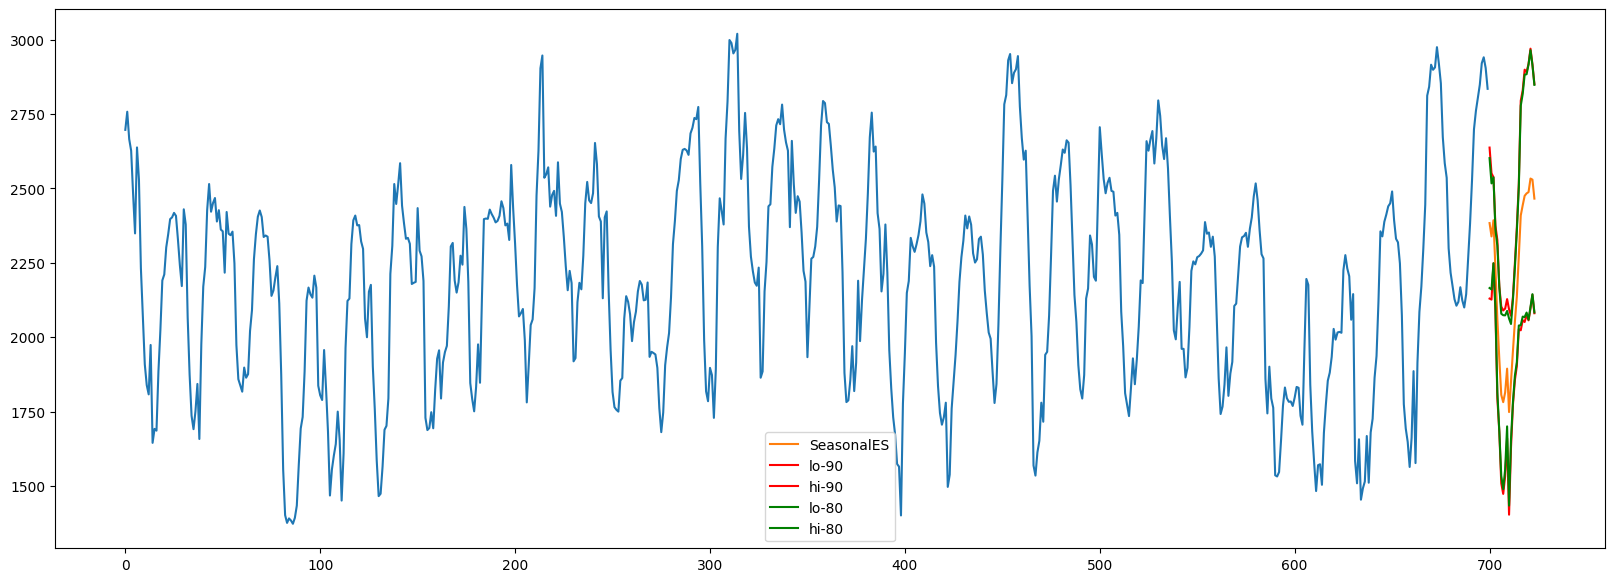

In [ ]:
_plot_fcst(temp_forecast, temp_train, "SeasonalES")

For weaker fitting models, the conformal prediction interval can be larger. A better model corresponds to a narrower interval.

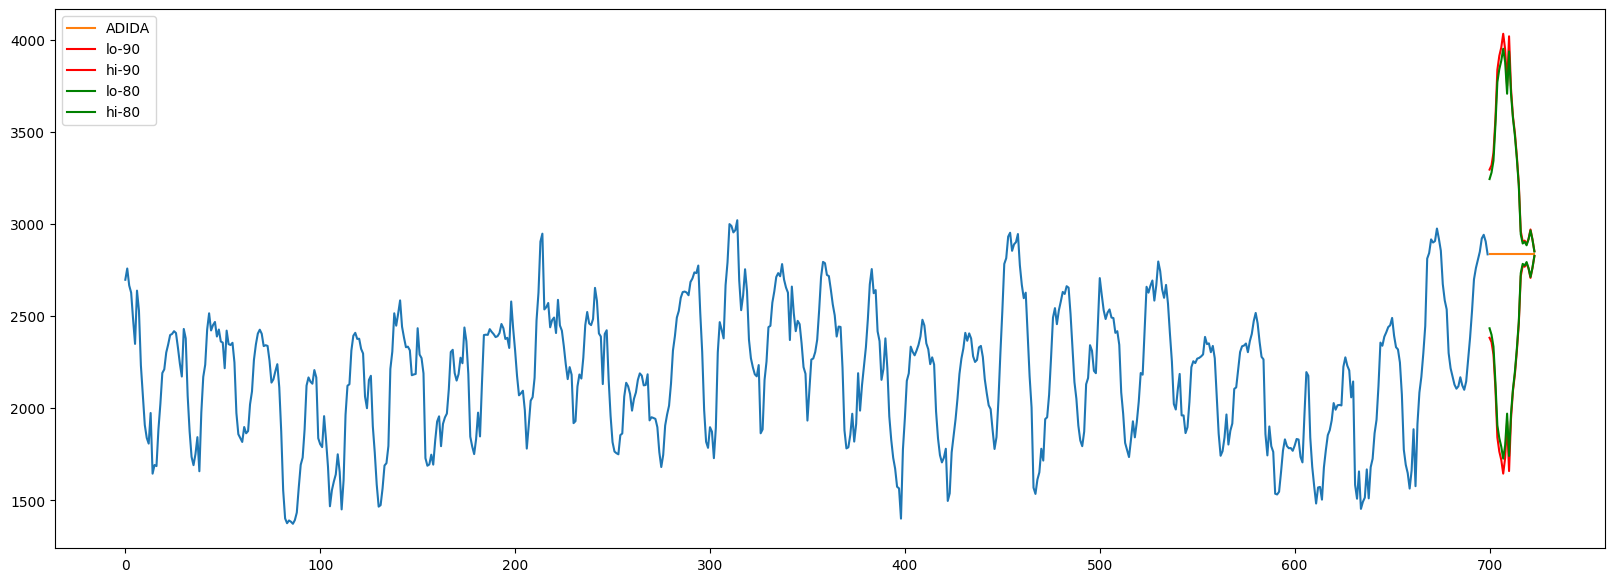

In [ ]:
_plot_fcst(temp_forecast, temp_train,"ADIDA")

ARIMA is an example of a model that provides a forecast distribution, but we can still use conformal prediction to generate the prediction interval. As mentioned earlier, this method has the benefit of not assuming normality.

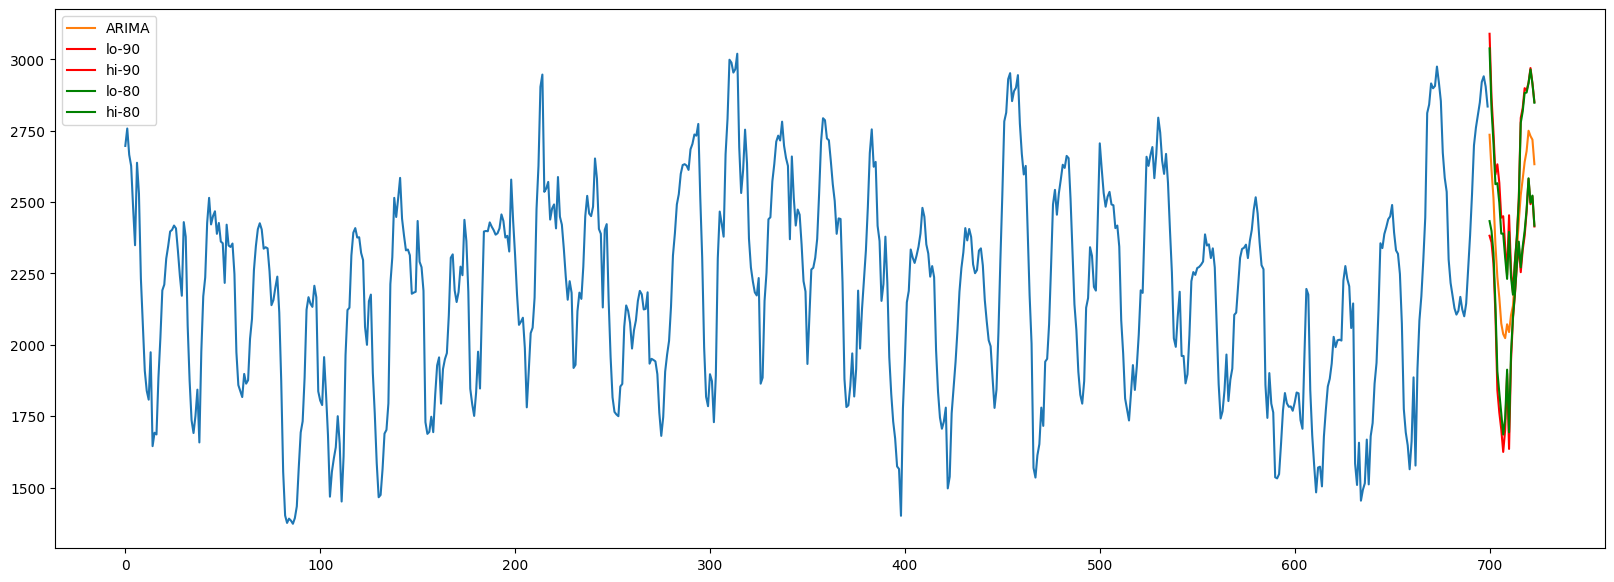

In [ ]:
_plot_fcst(temp_forecast, temp_train,"ARIMA")

## StatsForecast Object

Alternatively, the prediction interval can be defined on the StatsForecast object. This will apply to all models that don't have the `prediction_intervals` defined.

In [ ]:
from statsforecast.models import SimpleExponentialSmoothing, ADIDA
from statsforecast.utils import ConformalIntervals
from statsforecast import StatsForecast

models = [
    SimpleExponentialSmoothing(alpha=0.1),
    ADIDA()
]

res = StatsForecast(
    df=train, 
    models=models, 
    freq='H').forecast(h=24, prediction_intervals=ConformalIntervals(h=24, n_windows=2), level=[80]) 

res.head().reset_index()

,unique_id,ds,SES,SES-lo-80,SES-hi-80,ADIDA,ADIDA-lo-80,ADIDA-hi-80
0,H1,701,742.669067,672.099976,813.238159,747.292542,672.099976,822.485107
1,H1,702,742.669067,570.400024,914.938110,747.292542,570.400024,924.185059
2,H1,703,742.669067,549.700012,935.638123,747.292542,549.700012,944.885071
3,H1,704,742.669067,512.200012,973.138123,747.292542,512.200012,982.385071
4,H1,705,742.669067,489.299988,996.038147,747.292542,489.299988,1005.285095


## Future work

Conformal prediction has become a powerful framework for uncertainty quantification, providing well-calibrated prediction intervals without making any distributional assumptions. Its use has surged in both academia and industry over the past few years. We'll continue working on it, and future tutorials may include:

- Exploring larger datasets
- Incorporating industry-specific examples
- Investigating specialized methods like the jackknife+ that are closely related to conformal prediction (for details on the jackknife+ see [here](https://valeman.medium.com/jackknife-a-swiss-knife-of-conformal-prediction-for-regression-ce3b56432f4f)).

If you're interested in any of these, or in any other related topic, please let us know by opening an issue on [GitHub](https://github.com/Nixtla/statsforecast/issues)

## Acknowledgements
We would like to thank [Kevin Kho](https://github.com/kvnkho) for writing this tutorial, and Valeriy [Manokhin](https://github.com/valeman) for his expertise on conformal prediction, as well as for promoting this work.

## References

[Manokhin, Valery. (2022). Machine Learning for Probabilistic Prediction. 10.5281/zenodo.6727505. ](https://zenodo.org/record/6727505)